# 收缩树

通过order finder得到的order，我们转化为收缩树进行存储，以便后续优化order，选取slice。

相对于order finder中，我们只需要考虑连通图的结构，也只考虑detector的order顺序。但在contraction tree中，我们需要重新关注回超边的信息，描述每步收缩的超边。

我们还需要利用超边收缩顺序，得到每个超边的成本，超边相连的节点最早收缩和最晚收缩的时间差。

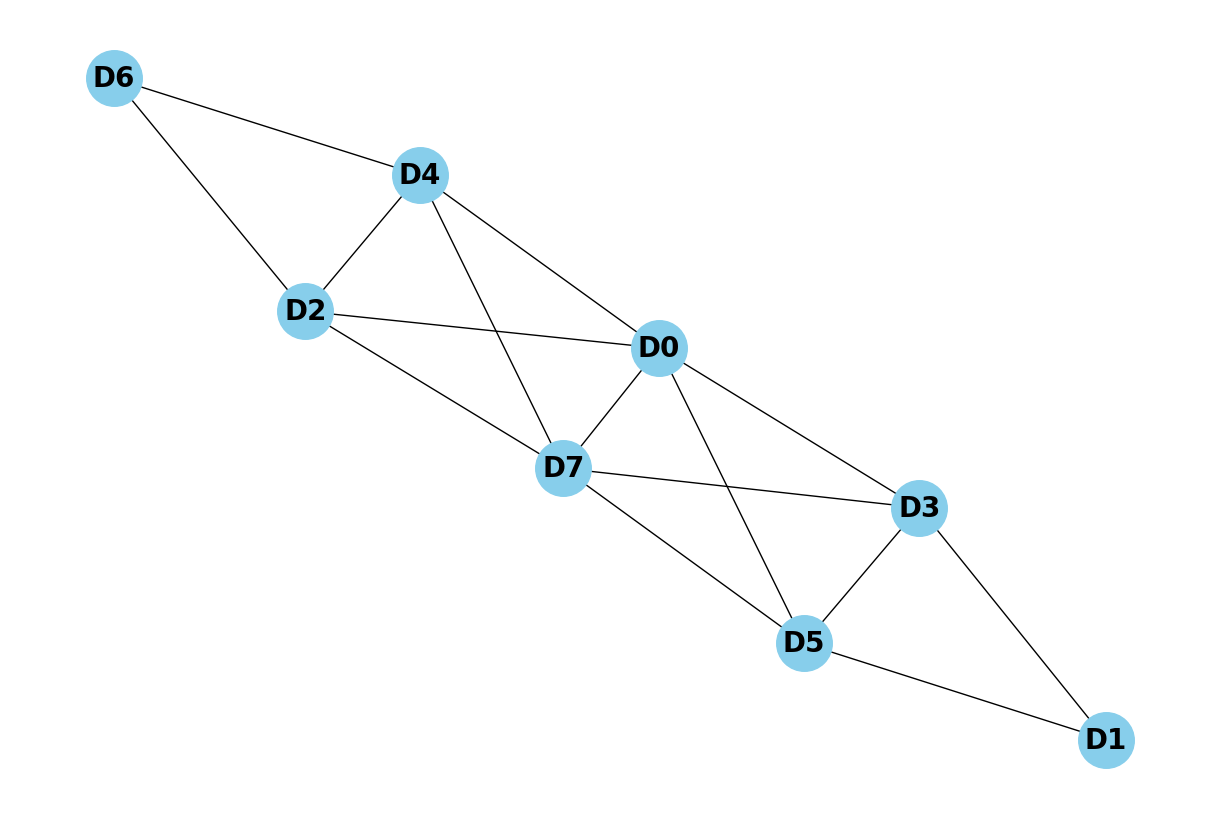

In [ ]:
import stim
from hamld.contraction_strategy.dem_to_hypergraph import DetectorErrorModelHypergraph
from hamld.contraction_strategy.hypergraph_to_connectivity import ConnectivityGraph

circuit_noisy = stim.Circuit.from_file("../data/external/google23/surface_code_bZ_d3_r01_center_3_5/circuit_noisy.stim")
detector_error_model = circuit_noisy.detector_error_model()

hypergraph = DetectorErrorModelHypergraph(detector_error_model=detector_error_model)
hypergraph_logical = DetectorErrorModelHypergraph(detector_error_model=detector_error_model, have_logical_observable=True)

connectivity_graph = ConnectivityGraph()
connectivity_graph.hypergraph_to_connectivity_graph(hypergraph)
connectivity_graph.draw()
from hamld.contraction_strategy.mld_order_finder import GreedyMLDOrderFinder

order_finder = GreedyMLDOrderFinder(connectivity_graph)
order = order_finder.find_order()

In [2]:
order

['D1', 'D3', 'D5', 'D0', 'D7', 'D2', 'D4', 'D6']

超图中会损失一点信息，我们还是将order和detector error model(或者可以用hypergraph_logical.hyperedges)作为输入。

In [ ]:
from hamld.contraction_strategy.contraction_tree import ContractionTree

In [4]:
contraction_tree = ContractionTree(order, detector_error_model=detector_error_model)

draw contraction tree

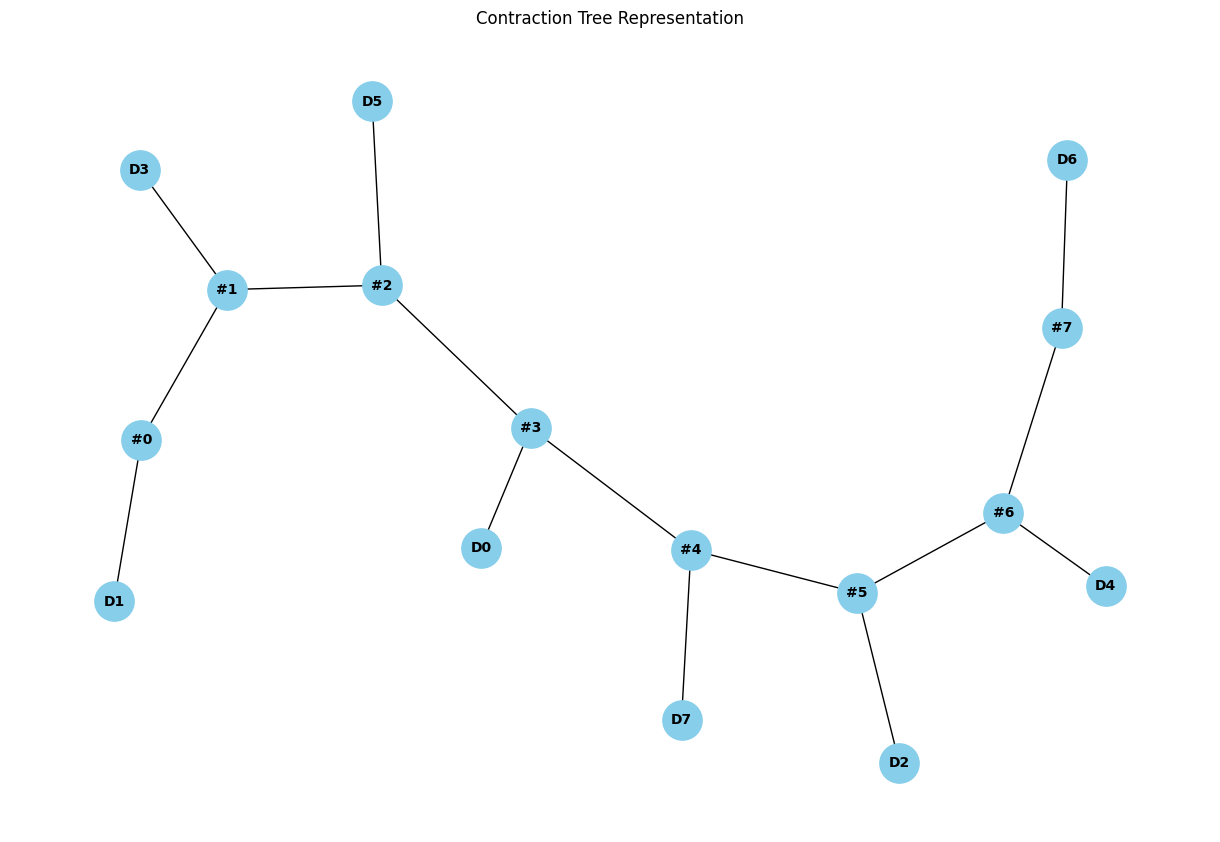

In [5]:
contraction_tree.draw_contraction_tree()

get cost information

In [6]:
contraction_cost, contraction_width, contraction_cost_each_step = contraction_tree.get_contraction_cost_information()

print(f"总收缩成本，表示收缩过程的时间: {contraction_cost}")
print(f"收缩过程中的最大宽度，表示内存的最大消耗: {contraction_cost}")
print(f"收缩过程中每步收缩的成本: {contraction_cost_each_step}")

总收缩成本，表示收缩过程的时间: 35
收缩过程中的最大宽度，表示内存的最大消耗: 35
收缩过程中每步收缩的成本: {'D1': 4, 'D3': 8, 'D5': 4, 'D0': 8, 'D7': 4, 'D2': 4, 'D4': 2, 'D6': 1}


In [7]:
edge_contractions, edge_contraction_steps = contraction_tree.get_contractions_hyperedge_information()
print(f"（超边，超边收缩步骤，超边相连节点最后收缩的步骤）: {edge_contractions}")
print(f"每个元素为 dict(超边: 收缩步骤)，具体如下： {edge_contraction_steps}")

（超边，超边收缩步骤，超边相连节点最后收缩的步骤）: [(('D0', 'D2'), 3, 5), (('D0', 'D3'), 1, 3), (('D0', 'D4'), 3, 6), (('D0', 'D5'), 2, 3), (('D0', 'D7'), 3, 4), (('D0', 'L0'), 3, 3), (('D1', 'D3'), 0, 1), (('D1', 'D5'), 0, 2), (('D1', 'L0'), 0, 0), (('D2',), 5, 5), (('D2', 'D4'), 5, 6), (('D2', 'D6'), 5, 7), (('D2', 'D7'), 4, 5), (('D3',), 1, 1), (('D3', 'D5'), 1, 2), (('D3', 'D7'), 1, 4), (('D4', 'D6'), 6, 7), (('D4', 'D7'), 4, 6), (('D4', 'L0'), 6, 6), (('D5', 'D7'), 2, 4), (('D5', 'L0'), 2, 2), (('D6',), 7, 7), (('D7',), 4, 4)]
每个元素为 dict(超边: 收缩步骤)，具体如下： {('D1', 'D3'): 0, ('D1', 'D5'): 0, ('D1', 'L0'): 0, ('D0', 'D3'): 1, ('D3',): 1, ('D3', 'D5'): 1, ('D3', 'D7'): 1, ('D0', 'D5'): 2, ('D5', 'D7'): 2, ('D5', 'L0'): 2, ('D0', 'D2'): 3, ('D0', 'D4'): 3, ('D0', 'D7'): 3, ('D0', 'L0'): 3, ('D2', 'D7'): 4, ('D4', 'D7'): 4, ('D7',): 4, ('D2',): 5, ('D2', 'D4'): 5, ('D2', 'D6'): 5, ('D4', 'D6'): 6, ('D4', 'L0'): 6, ('D6',): 7}


排序超边，根据超边的成本，这将会是slice_finder部分的核心思想。

In [8]:
sorted_edge_contractions = sorted(edge_contractions, key=lambda x: x[2] - x[1], reverse= True)
print(f"基于超边slice成本排序: {sorted_edge_contractions}")

基于超边slice成本排序: [(('D0', 'D4'), 3, 6), (('D3', 'D7'), 1, 4), (('D0', 'D2'), 3, 5), (('D0', 'D3'), 1, 3), (('D1', 'D5'), 0, 2), (('D2', 'D6'), 5, 7), (('D4', 'D7'), 4, 6), (('D5', 'D7'), 2, 4), (('D0', 'D5'), 2, 3), (('D0', 'D7'), 3, 4), (('D1', 'D3'), 0, 1), (('D2', 'D4'), 5, 6), (('D2', 'D7'), 4, 5), (('D3', 'D5'), 1, 2), (('D4', 'D6'), 6, 7), (('D0', 'L0'), 3, 3), (('D1', 'L0'), 0, 0), (('D2',), 5, 5), (('D3',), 1, 1), (('D4', 'L0'), 6, 6), (('D5', 'L0'), 2, 2), (('D6',), 7, 7), (('D7',), 4, 4)]


### 查看tree的具体情况

目前对于contraction_tree.tree_graph的节点部分，我们设计在每个叶子节点中存储parent代码。

在每个非叶子节点（主干节点），我们存储其parent以及该步的成本（具体定义可以参考论文，为概率分布的size）。

In [9]:
print(contraction_tree.tree_graph.nodes(data=True))

[('D0', {'parent': '#3'}), ('D1', {'parent': '#0'}), ('D2', {'parent': '#5'}), ('D3', {'parent': '#1'}), ('D4', {'parent': '#6'}), ('D5', {'parent': '#2'}), ('D6', {'parent': '#7'}), ('D7', {'parent': '#4'}), ('#0', {'parent': '#1', 'contraction_cost': 4}), ('#1', {'parent': '#2', 'contraction_cost': 8}), ('#2', {'parent': '#3', 'contraction_cost': 4}), ('#3', {'parent': '#4', 'contraction_cost': 8}), ('#4', {'parent': '#5', 'contraction_cost': 4}), ('#5', {'parent': '#6', 'contraction_cost': 4}), ('#6', {'parent': '#7', 'contraction_cost': 2}), ('#7', {'contraction_cost': 1})]


对于每个叶子节点与非叶子节点的边，我们称为brach（分支），在分支中，我们会存储当前收缩的步骤，以及收缩的超边（错误机制）有那些。

In [10]:
print(contraction_tree.tree_graph.edges(data=True))

[('D0', '#3', {'step': 3, 'contraction_hyperedges': [('D0', 'D2'), ('D0', 'D4'), ('D0', 'D7'), ('D0', 'L0')]}), ('D1', '#0', {'step': 0, 'contraction_hyperedges': [('D1', 'D3'), ('D1', 'D5'), ('D1', 'L0')]}), ('D2', '#5', {'step': 5, 'contraction_hyperedges': [('D2',), ('D2', 'D4'), ('D2', 'D6')]}), ('D3', '#1', {'step': 1, 'contraction_hyperedges': [('D0', 'D3'), ('D3',), ('D3', 'D5'), ('D3', 'D7')]}), ('D4', '#6', {'step': 6, 'contraction_hyperedges': [('D4', 'D6'), ('D4', 'L0')]}), ('D5', '#2', {'step': 2, 'contraction_hyperedges': [('D0', 'D5'), ('D5', 'D7'), ('D5', 'L0')]}), ('D6', '#7', {'step': 7, 'contraction_hyperedges': [('D6',)]}), ('D7', '#4', {'step': 4, 'contraction_hyperedges': [('D2', 'D7'), ('D4', 'D7'), ('D7',)]}), ('#0', '#1', {}), ('#1', '#2', {}), ('#2', '#3', {}), ('#3', '#4', {}), ('#4', '#5', {}), ('#5', '#6', {}), ('#6', '#7', {})]
